# Introduction
The main focus of this project is to attempt to build and test a couple of machine learning models that could predict the quality or alcohol content of a wine. The dataset we will be using can be found at [kaggle](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009). Among building models we will perform basic exploratory data analysis, visualize our findings and use statistical tests for our hypotheses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression

In [2]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Data cleaning

In [3]:
df_size = df.shape

We see that we start off with 1599 entries before data cleaning, we will look for duplicate entries and null values as they could negatively impact the performance of our model.

In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
df.duplicated().sum()

240

We see that we have no null values, but there are some duplicates, we will be removing them.

In [6]:
df = df.drop_duplicates()
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We see a summary of our data. We can also mention what are the units of measurement of our features:
* Fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, sulphates are measured in g/l.
* Free sulfur dioxide and total sulfur dioxide are measured in ppm or mg/l.
* Density is measured in g/ml.
* pH has no unit.
* Alcohol is measured in % v/v.
* Quality also has no unit of measurement.
We have 11 numerical variables and 1 categorical variable.

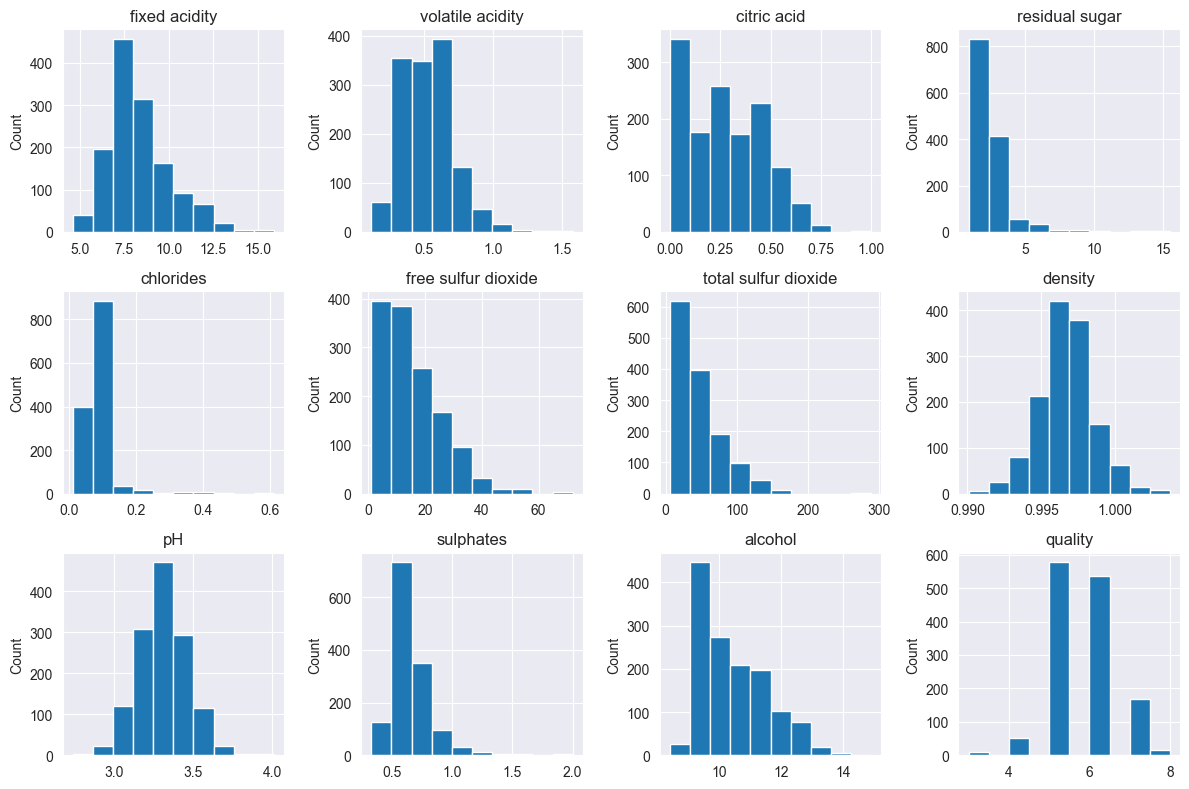

In [7]:
fig, ax = plt.subplots(3, 4, figsize=(12,8))
for i in range(3):
    for j in range(4):
        ax[i, j].hist(df.iloc[:, i*4+j])
        ax[i, j].set_title(df.columns[i*4+j])
        ax[i, j].set_ylabel('Count')
plt.tight_layout()

We can see the distributions, histograms of our variables, most of them are skewed in some way or in the case of citric acid have multiple peaks and in general have some outliers, we'll remove the outliers as they will impact our models' predictions. We will be using the IQR method to do so. We will remove data points outside 1.5 IQR.

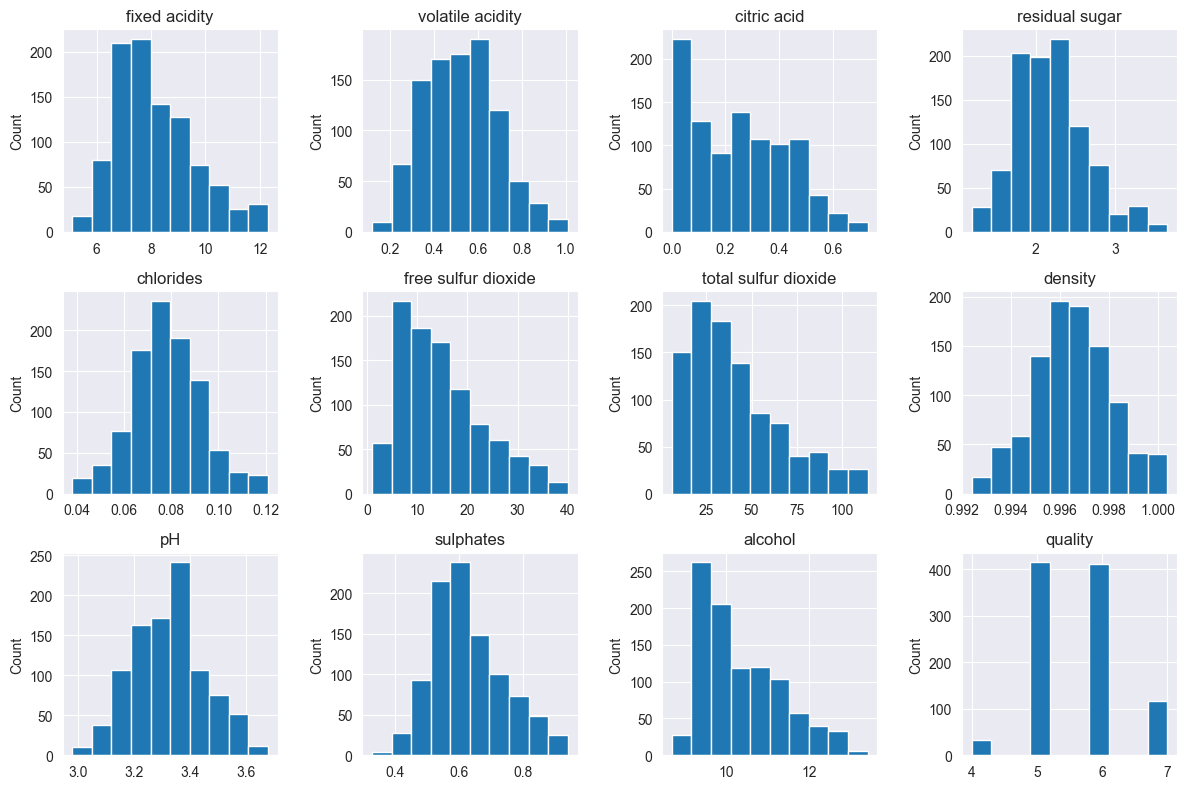

In [8]:
threshold = 1.5
for col in df.columns:
    q25, q75 = df[col].quantile(q=0.25), df[col].quantile(q=0.75)
    iqr = q75 - q25
    lower_bound = q25 - threshold * iqr
    upper_bound = q75 + threshold * iqr
    df = df.where((df[col] > lower_bound) & (df[col] < upper_bound))
df = df.dropna()

fig, ax = plt.subplots(3, 4, figsize=(12, 8))
for i in range(3):
    for j in range(4):
        ax[i, j].hist(df.iloc[:, i * 4 + j])
        ax[i, j].set_title(df.columns[i * 4 + j])
        ax[i, j].set_ylabel('Count')
plt.tight_layout()

We can see that after removing the outliers, the distributions seem a bit more normal.

In [9]:
(1-df.shape[0]/df_size[0])*100

39.086929330831765

We can see that we got rid of 39% of our data by removing duplicate entries and outliers.

In [10]:
df['quality'].value_counts()

quality
5.0    415
6.0    411
7.0    116
4.0     32
Name: count, dtype: int64

We are left with quality ratings of 4, 5, 6 and 7.

In [11]:
df_ranges = df.describe().loc[['min', 'max'], :]
df_ranges

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
min,5.1,0.12,0.00,1.20,0.038,1.0,6.0,0.9924,2.98,0.33,8.7,4.0
max,12.3,1.01,0.73,3.65,0.121,40.0,114.0,1.0004,3.68,0.94,13.4,7.0


Here we have ranges for variables in which our model should be able to perform the best. Before moving to building models, I would like to check which wines tend to be considered better quality, the ones with low or high amount of residual sugar.
# Statistical Inference
We reimport the dataset as in the previous one the semi sweet wines got tagged as outliers and got removed. We will categorize the wines into dry and semi sweet and look how their quality is distributed.

In [12]:
df_hypothesis = pd.read_csv('winequality-red.csv')
df_hypothesis = df_hypothesis.drop_duplicates()
df_hypothesis = df_hypothesis[['residual sugar', 'quality']]

In [13]:
bins = [0, 5, 35]
labels = ['Dry', 'Semi Sweet']
df_hypothesis['grade'] = pd.cut(df_hypothesis['residual sugar'], bins=bins, labels=labels)
df_hypothesis = df_hypothesis.drop('residual sugar', axis=1).value_counts()
df_hypothesis = df_hypothesis.unstack()

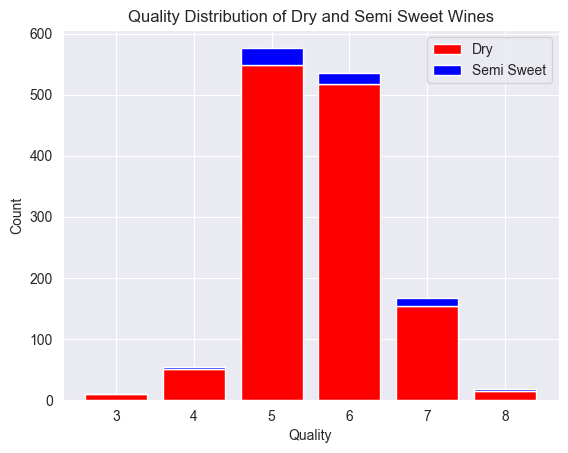

In [14]:
plt.bar(df_hypothesis.index, df_hypothesis['Dry'], color='r')
plt.bar(df_hypothesis.index, df_hypothesis['Semi Sweet'], bottom=df_hypothesis['Dry'], color='b')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Quality Distribution of Dry and Semi Sweet Wines')
plt.legend(['Dry', 'Semi Sweet']);

In [15]:
df_hypothesis

grade,Dry,Semi Sweet
quality,,
3,9,1
4,50,3
5,549,28
6,517,18
7,153,14
8,15,2


We see that majority of the wines in the dataset are semi sweet and that there are very low amounts of semi sweet wines with ratings 3, 4 and 8. I want to find out whether semi sweet wines or dry wines tend to be better quality on average. For that we'll be conducting a t-test, our target population will be dry and semi sweet wines, our null hypothesis states that the means of these wine qualities are the same, meaning there's no difference between them, and our alternative hypothesis is that semi sweet wines tend to be higher quality on average. We will choose a significance level of 0.05. We need to make a few assumptions about our sample:
1. Our sample is a simple random sample. Since we don't know how the data was collected we cannot claim with certainty that it is, however for the sake of being able to proceed we'll say that it is.
2. Our samples are independent of one another.
3. Our samples are normally distributed, or we have large enough sample size.

Dry wine quality mean: 5.62
 Semi Sweet wine quality mean: 5.71


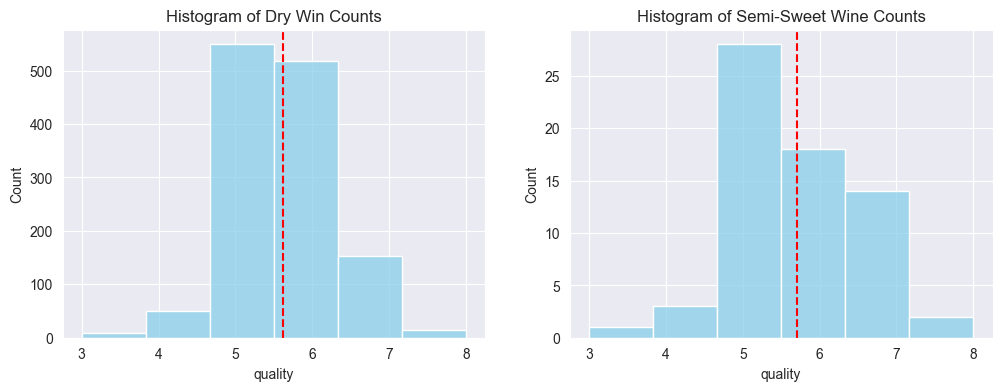

In [16]:
dry_mean = (df_hypothesis.index * df_hypothesis['Dry']/df_hypothesis['Dry'].sum()).sum()
semi_sweet_mean = (df_hypothesis.index * df_hypothesis['Semi Sweet']/df_hypothesis['Semi Sweet'].sum()).sum()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=df_hypothesis, x=df_hypothesis.index, weights='Dry', bins=6, color='skyblue', ax=ax[0])
ax[0].axvline(x=dry_mean, color='red', linestyle='--')
ax[0].set_title('Histogram of Dry Win Counts')
sns.histplot(data=df_hypothesis, x=df_hypothesis.index, weights='Semi Sweet', bins=6, color='skyblue', ax=ax[1])
ax[1].axvline(x=semi_sweet_mean, color='red', linestyle='--')
ax[1].set_title('Histogram of Semi-Sweet Wine Counts')
print(f'Dry wine quality mean: {dry_mean:.2f}\n Semi Sweet wine quality mean: {semi_sweet_mean:.2f}')

Dry wine sampling mean: 5.62
 Semi Sweet wine sampling mean: 5.71
Dry wine sampling distribution skew: 0.09
 Semi Sweet wine sampling mean: 0.05


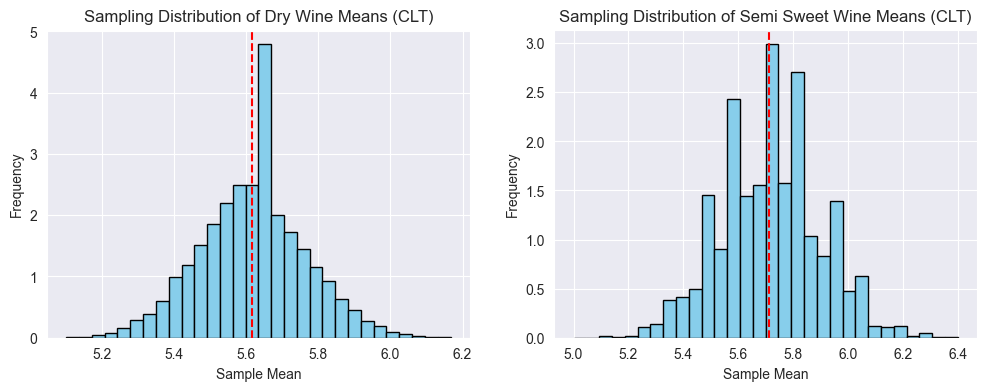

In [17]:
dry_df = pd.DataFrame({'Dry': df_hypothesis.index.repeat(df_hypothesis['Dry'])})
semi_sweet_df = pd.DataFrame({'Semi Sweet': df_hypothesis.index.repeat(df_hypothesis['Semi Sweet'])})

num_samples = 10000
sample_size = 30
dry_sample_means = []
semi_sweet_sample_means = []

for _ in range(num_samples):
    dry_sample = np.random.choice(dry_df['Dry'], size=sample_size, replace=True)
    semi_sweet_sample = np.random.choice(semi_sweet_df['Semi Sweet'], size=sample_size, replace=True)
    dry_sample_mean = np.mean(dry_sample)
    semi_sweet_sample_mean = np.mean(semi_sweet_sample)
    dry_sample_means.append(dry_sample_mean)
    semi_sweet_sample_means.append(semi_sweet_sample_mean)

dry_sample_mean = np.mean(dry_sample_means)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(dry_sample_means, bins=30, density=True, color='skyblue', edgecolor='black')
ax[0].axvline(x=dry_sample_mean, color='red', linestyle='--')
ax[0].set_xlabel('Sample Mean')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Sampling Distribution of Dry Wine Means (CLT)')

semi_sweet_sample_mean = np.mean(semi_sweet_sample_means)
ax[1].hist(semi_sweet_sample_means, bins=30, density=True, color='skyblue', edgecolor='black')
ax[1].axvline(x=semi_sweet_sample_mean, color='red', linestyle='--')
ax[1].set_xlabel('Sample Mean')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Sampling Distribution of Semi Sweet Wine Means (CLT)')

print(f'Dry wine sampling mean: {dry_sample_mean:.2f}\n Semi Sweet wine sampling mean: {semi_sweet_sample_mean:.2f}')
print(f'Dry wine sampling distribution skew: {pd.DataFrame(dry_sample_means).skew()[0]:.2f}\n Semi Sweet wine sampling mean: {pd.DataFrame(semi_sweet_sample_means).skew()[0]:.2f}')

Here we see that even though we don't seem to have the most perfect distribution of quality, we can still use the mean because we have large enough sample size where if we resample and calculate the average, the mean of those averages that is distributed normally is still going to be roughly the mean of the primary distribution. Next we will calculate, t-statistic, p-value.

In [18]:
t_statistic, p_value = stats.ttest_ind(semi_sweet_df, dry_df)
print(f'T-statistic: {t_statistic}, P-value: {p_value/2}')

T-statistic: [0.89866193], P-value: [0.18449609]


From the calculated p-value we cannot reject the null hypothesis and say that the quality of an average semi sweet wine is higher than that of an average dry wine. Moving on we'll start building our model.
# Predicting Quality with Ordinary Least Squares Linear Regression Model
The first model we will try to fit is going to be linear regression model using OLS method. First we'll plot out independent variables against our dependent variable as well as plot a regression line to see if we can get some insights from them.

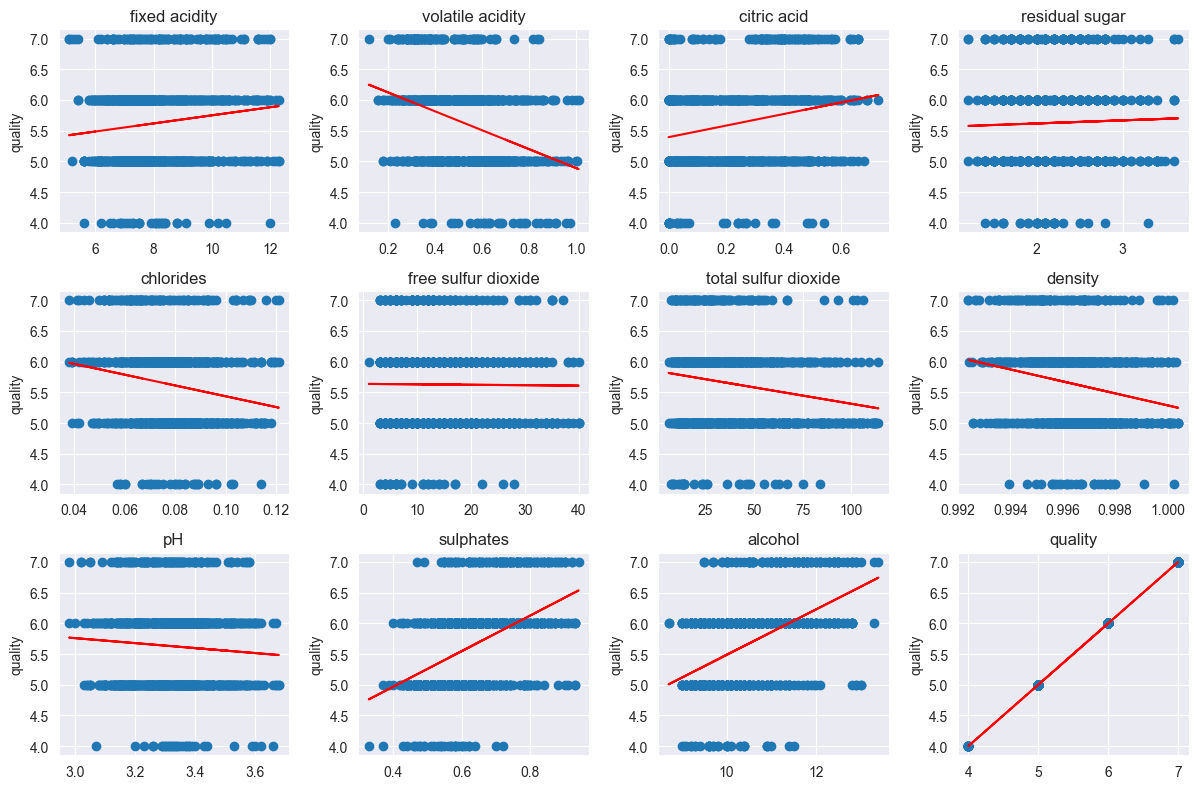

In [19]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
for i in range(3):
    for j in range(4):
        slope, intercept = np.polyfit(df.iloc[:, i * 4 + j], df['quality'], 1)
        regression_line = slope * df.iloc[:, i * 4 + j] + intercept
        ax[i, j].scatter(df.iloc[:, i * 4 + j], df['quality'])
        ax[i, j].plot(df.iloc[:, i * 4 + j], regression_line, color='red')
        ax[i, j].set_title(df.columns[i * 4 + j])
        ax[i, j].set_ylabel('quality')
plt.tight_layout()

As we see since our dependent variable is not a continuous variable the scatter plots have incremented gaps on the y-axis. From the regression line we can see how "quality" changes as an independent variable increases. We see that the amount of variables that positively correlate with "quality" is about the same as the ones that negatively correlate. We can get a numeric expression by making a correlation matrix.

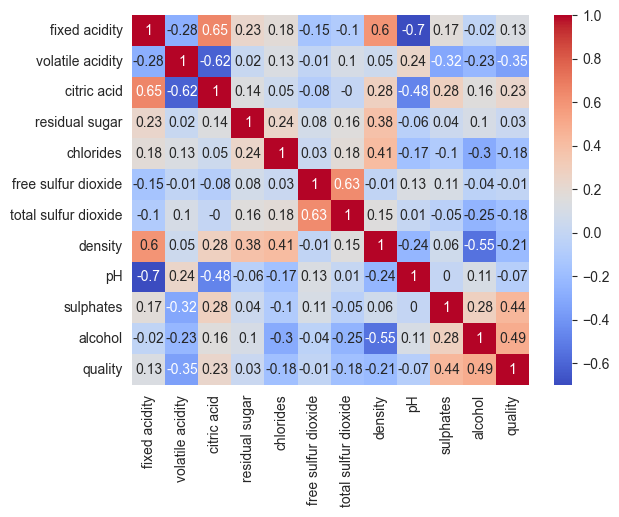

In [20]:
sns.heatmap(round(df.corr(), 2), annot=True, cmap='coolwarm');

From this heatmap we can see how strongly features correlate with each other. When looking at quality, we see that most features have relatively weak correlation, except for alcohol, sulphates and maybe volatile acidity. When looking at other features we can see that some of them tend to correlate with each other and this could pose a problem. Multicollinearity, when multiple independent variables correlate with each other, tends to negatively affect the reliability of our model and results, we would like to reduce it as much as possible. Before fitting our model we will split our remaining dataset into training and testing datasets.

In [21]:
x = df.iloc[:, :-1]
y = df['quality']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_test = sm.add_constant(x_train), sm.add_constant(x_test)

We have added a constant to the x_train and x_test dataframes as statsmodels package functions do not automatically add one when fitting a model. This will give us the intercept value. The model that we will be fitting is going to be linear regression model using ordinary least squares method. It fits the best fitting line through our data points in a way that it minimizes the sum of squared differences between the observed and predicted values.

In [22]:
ols_model = sm.OLS(y_train, x_train).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     44.89
Date:                Wed, 06 Sep 2023   Prob (F-statistic):           2.09e-75
Time:                        22:48:56   Log-Likelihood:                -668.62
No. Observations:                 779   AIC:                             1361.
Df Residuals:                     767   BIC:                             1417.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   19.0031 

From the summary we get a few metrics.
1. R-squared shows how well the model fits the data, we see that not that much data is accounted for in the model.
2. Adjusted R-squared a modified version of the prior that penalizes for adding unnecessary variables to the model.
3. F-statistic tells us whether at least one of the independent variables is statistically significant.
4. Independent variable coefficients tells us what impact a change of 1 unit of measurement has on the dependent variable.
5. t-statistic and its p-value assesses whether an independent variable has a statistically significant effect on the dependent variable the p-value is derived from it and generally if it is above 0.05 it means that the independent variable could be zero and does not have a meaningful effect on the dependent variable.

We can see from the summary that our R-squared value is quite low, meaning that most of the data is not accounted for in the model, looking at the 2nd part of the summary we see that a lot of our independent variables have quite high p-values meaning that they are not statistically significant in this model. We also see a warning about multicollinearity, which we saw in the correlation matrix earlier.

As this type of model does not seem to be a good fit to our data we can still test on how well it does. One of the metrics is we could measure it by would be root mean square error.


In [23]:
predicted = ols_model.predict(x_test)
mse = mean_squared_error(y_test,predicted)
rmse = mse**0.5
print(f'RMSE: {rmse} MSE: {mse}')

RMSE: 0.596071169923064 MSE: 0.35530083961345016


In [24]:
predicted = round(ols_model.predict(x_test))
residuals = y_test - predicted
accuracy = residuals.value_counts().iloc[0]/(residuals.value_counts().sum())*100
accuracy

64.1025641025641

We can see that on average our predictions are roughly 0.59 of a rating measurement incorrect and our accuracy is around 64%. We can perform cross validation to reassure ourselves that these measurements were not due to chance.

In [25]:
kf = KFold(n_splits=5)
results = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    x_train, x_test = sm.add_constant(x_train), sm.add_constant(x_test)
    ols_model = sm.OLS(y_train, x_train).fit()
    predicted = ols_model.predict(x_test)
    mse = mean_squared_error(y_test,predicted)
    rmse = mse**0.5
    residuals = y_test - predicted.round()
    residuals = pd.DataFrame(residuals)
    accuracy = residuals.value_counts().iloc[0]/(residuals.value_counts().sum())*100
    results.append([rmse, accuracy])
validation_df = pd.DataFrame(results, columns=['RMSE', 'Accuracy'])
validation_df

,RMSE,Accuracy
0,0.596078,58.974359
1,0.554270,60.512821
2,0.612453,62.564103
3,0.581614,55.897436
4,0.579333,61.340206


In [26]:
validation_df.describe()

,RMSE,Accuracy
count,5.000000,5.000000
mean,0.584749,59.857785
std,0.021587,2.569806
min,0.554270,55.897436
25%,0.579333,58.974359
50%,0.581614,60.512821
75%,0.596078,61.340206
max,0.612453,62.564103


We see that the average error is roughly 0.58 and accuracy is around 60%. We see that this linear regression model is not the best at predicting values with our data that has not been transformed in any way, therefore we will try to look at some alternatives to try and find a better model.
# Predicting Quality with Polynomial (2nd degree) Linear Regression Model
Polynomial regression allows us to model relationship between our variables as nth-degree polynomial. However, it is very prone to overfitting. It will have a greater impact on outliers than on non-outliers, causing low values to become even lower and high values to become even higher by comparison.

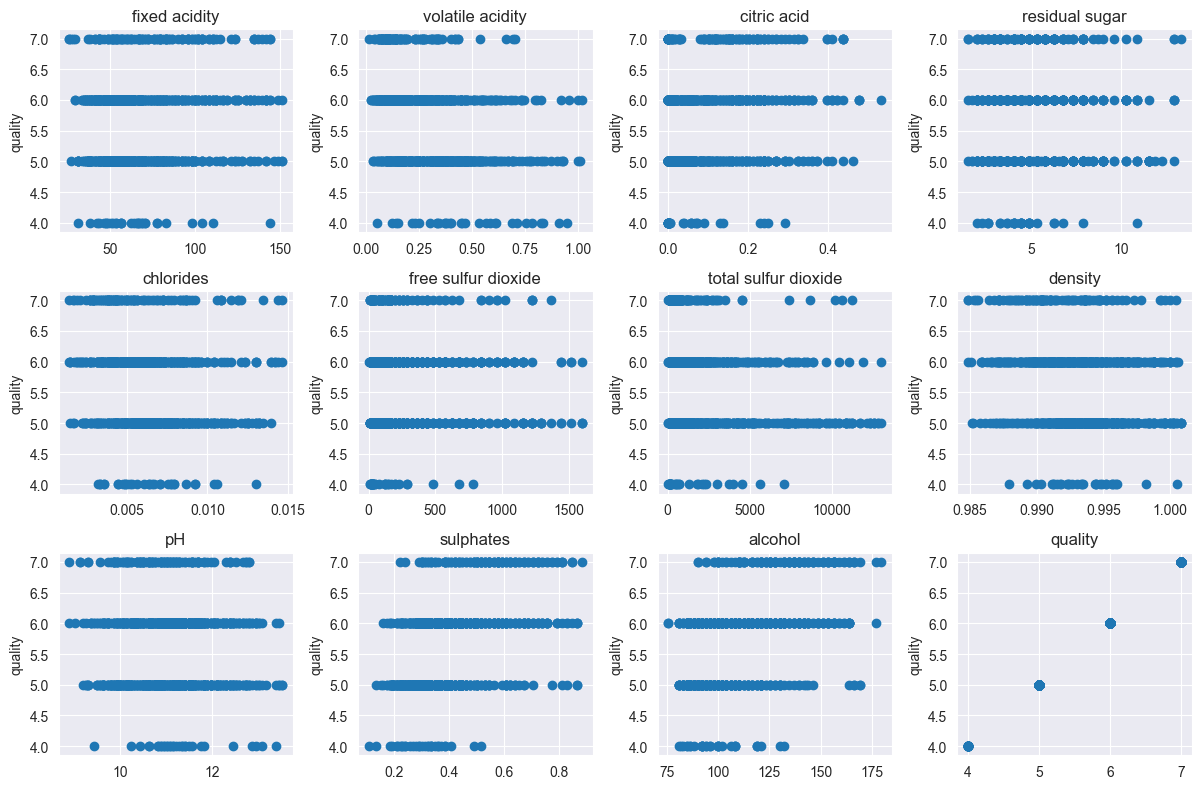

In [27]:
raised_df = df.iloc[:, :-1]**2
raised_df = raised_df.join(df['quality'])
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
for i in range(3):
    for j in range(4):
        ax[i, j].scatter(raised_df.iloc[:, i * 4 + j], df['quality'])
        ax[i, j].set_title(raised_df.columns[i * 4 + j])
        ax[i, j].set_ylabel('quality')
plt.tight_layout()

Here we can see the relationship between quality and 2nd degree polynomial. The variables seem to be more dragged out, not surprisingly having higher variability, sometimes lower min values and higher max values. We can train and fit a polynomial regression model using scikit-learn package.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
poly = PolynomialFeatures(degree=2)
x_train, x_test = poly.fit_transform(x_train), poly.transform(x_test)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse**0.5
print(f'Intercept: {model.intercept_}\nCoefficients: {model.coef_}\nR^2: {model.score(x_test, y_test)} RMSE: {rmse}, MSE {mse}')

Intercept: -10881.13805844532
Coefficients: [ 1.09206208e-03 -5.57231504e+01  1.96368781e+02  2.16674224e+02
 -7.06209719e+01  6.58140471e+02 -4.81300977e+00 -1.25394753e+00
  2.23444320e+04 -2.65389665e+02  2.11197967e+02  7.42722119e+01
 -6.26457614e-02  1.68181934e-01  2.25328524e-01 -7.33710748e-02
 -2.05623477e-01 -1.74542577e-03 -2.86465741e-03  5.89295571e+01
 -8.16195994e-01  8.36113354e-01  3.80938953e-02  1.20677195e+00
  3.11449116e+00  5.57272574e-01 -3.29501545e+00  5.27547464e-02
 -8.62345860e-03 -2.06401140e+02  1.20408352e+00 -3.13519522e+00
  1.63024409e-01  6.62150207e-01  6.84693967e-01 -4.23129120e+00
  6.59042752e-02 -1.12904166e-02 -2.22867223e+02  3.75525530e-01
 -2.88199632e+00  1.07647363e-02 -1.23572646e-01  3.90606399e-01
 -4.45564750e-03 -3.47608458e-03  7.20737089e+01 -4.35527514e-01
  3.02475331e-02  1.01675341e-01  2.55044983e+01 -3.14592554e-01
  8.02644049e-02 -7.26383507e+02  3.67683594e+00  8.68218527e+00
  4.64652109e+00 -5.54868345e-04 -1.48459546e-

In [29]:
rounded_up = np.where(np.mod(predictions, 1) >= 0.5, np.ceil(predictions), np.floor(predictions))
residuals = y_test - rounded_up
accuracy = residuals.value_counts().iloc[0]/(residuals.value_counts().sum())*100
accuracy

64.1025641025641

As we can see this model has a lot more coefficients when compared to the OLS model, as well as it's intercept is very low. R^2 is also lower and RMSE is higher, with accuracy staying around the same. We can once again cross validate using K-Folds method.

In [30]:
kf = KFold(n_splits=5)
results = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    x_train, x_test = poly.fit_transform(x_train), poly.transform(x_test)
    model = LinearRegression()
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    mse = mean_squared_error(y_test,predicted)
    rmse = mse**0.5
    residuals = y_test - predicted.round()
    residuals = pd.DataFrame(residuals)
    accuracy = residuals.value_counts().iloc[0]/(residuals.value_counts().sum())*100
    results.append([rmse, accuracy])
validation_df = pd.DataFrame(results, columns=['RMSE', 'Accuracy'])
validation_df

,RMSE,Accuracy
0,0.663676,53.846154
1,0.619534,51.794872
2,0.634545,56.923077
3,0.607767,60.000000
4,0.579131,58.762887


In [31]:
validation_df.describe()

,RMSE,Accuracy
count,5.000000,5.000000
mean,0.620931,56.265398
std,0.031365,3.407917
min,0.579131,51.794872
25%,0.607767,53.846154
50%,0.619534,56.923077
75%,0.634545,58.762887
max,0.663676,60.000000


We can see that the model performed relatively well on the training data and comparatively poorly during cross validation, indicating that it could have been susceptible to overfitting. Other than that, it would seem that a polynomial regression model is not a better fit when compared to the OLS model, we had lower accuracy and R^2, higher RMSE and bigger standard deviations for accuracy and RMSe during cross validation.
# Predicting Quality with Elastic Net Regression Model
Elastic Net regression involves combining Lasso and Ridge regularization techniques. It tries to minimize the sum of squared residuals and penalizes large and irrelevant coefficients. In our case it might be able to address the problem of collinearity.

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
alpha = 0.1
l1_ratio = 0.5
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elastic_net.fit(x_train, y_train)
y_pred = elastic_net.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
ssr = np.sum(np.square(y_pred - y_test))
print(f'Intercept: {elastic_net.intercept_}\nCoefficients: {elastic_net.coef_}\nR^2: {elastic_net.score(x_test, y_test)} RMSE: {rmse}, MSE {mse}')

Intercept: 2.255133149198016
Coefficients: [ 0.04649676 -0.          0.         -0.         -0.          0.00972629
 -0.0038213  -0.         -0.          0.          0.28886033]
R^2: 0.23259754572645164 RMSE: 0.6467474535696639, MSE 0.41828226869884455


In [33]:
x_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

We can see that the alpha parameter, the strength of regularization removed most of the features deeming them irrelevant. The only features that were included were fixed acidity, free sulfur dioxide, total sulfur dioxide and alcohol. We can see that the intercept compared to the other models is fairly reasonable and RMSE is very similar to the polynomial model. However, we can see that R^2 is worse when compared to both of the previous models.

In [34]:
rounded_up = np.where(np.mod(y_pred, 1) >= 0.5, np.ceil(y_pred), np.floor(y_pred))
residuals = y_test - rounded_up
accuracy = residuals.value_counts().iloc[0]/(residuals.value_counts().sum())*100
accuracy

58.97435897435898

In [35]:
kf = KFold(n_splits=5)
results = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net.fit(x_train, y_train)
    predicted = elastic_net.predict(x_test)
    mse = mean_squared_error(y_test, predicted)
    rmse = mse**0.5
    residuals = y_test - predicted.round()
    residuals = pd.DataFrame(residuals)
    accuracy = residuals.value_counts().iloc[0]/(residuals.value_counts().sum())*100
    results.append([rmse, accuracy])
validation_df = pd.DataFrame(results, columns=['RMSE', 'Accuracy'])
validation_df

,RMSE,Accuracy
0,0.609077,62.564103
1,0.596550,57.435897
2,0.665937,54.358974
3,0.656577,53.333333
4,0.638197,58.247423


In [36]:
validation_df.describe()

,RMSE,Accuracy
count,5.000000,5.000000
mean,0.633268,57.187946
std,0.029867,3.638274
min,0.596550,53.333333
25%,0.609077,54.358974
50%,0.638197,57.435897
75%,0.656577,58.247423
max,0.665937,62.564103


Looking at the accuracy and RMSE we see that they're actually worse than the OLS model's but accuracy is better than polynomial model's. So far out of the 3 types of regression models we have tested, the OLS model seemed to perform the best. Any data of which we would try to make predictions, should follow similar ranges as the dataset that it was trained on. These are the ranges of a dataset from which our training data came from:

In [37]:
df_ranges

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
min,5.1,0.12,0.00,1.20,0.038,1.0,6.0,0.9924,2.98,0.33,8.7,4.0
max,12.3,1.01,0.73,3.65,0.121,40.0,114.0,1.0004,3.68,0.94,13.4,7.0


We should also take into account that our dependent variable is categorical so classification model might do better than regression model.
# Predicting Quality With Multinomial Logistic Regression Model
Multinomial logistic regression is used to model the relationship between multiple categories of dependent variable, in our case we have multiple categories of rating (4, 5 ,6 ,7), and one or more independent variables.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
model = LogisticRegression(multi_class='multinomial', max_iter=10000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[ 0,  4,  2,  0],
       [ 0, 65, 16,  0],
       [ 0, 30, 49,  4],
       [ 0,  3, 18,  4]], dtype=int64)

In [39]:
y_test.value_counts()

quality
6.0    83
5.0    81
7.0    25
4.0     6
Name: count, dtype: int64

In [40]:
pd.DataFrame(y_pred).value_counts()

5.0    102
6.0     85
7.0      8
Name: count, dtype: int64

In [41]:
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         6
         5.0       0.64      0.80      0.71        81
         6.0       0.58      0.59      0.58        83
         7.0       0.50      0.16      0.24        25

    accuracy                           0.61       195
   macro avg       0.43      0.39      0.38       195
weighted avg       0.57      0.61      0.57       195



C:\Users\tomas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tomas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tomas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [42]:
kf = KFold(n_splits=5)
accuracy_scores = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LogisticRegression(multi_class='multinomial', max_iter=10000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

In [43]:
print(f'Accuracy List: {accuracy_scores}\nMean Accuracy: {mean_accuracy:.2f}\n Standard Deviation of Accuracy: {std_accuracy:.2f}')

Accuracy List: [0.6051282051282051, 0.5897435897435898, 0.5846153846153846, 0.5282051282051282, 0.6237113402061856]
Mean Accuracy: 0.59
 Standard Deviation of Accuracy: 0.03


Looking at the results of cross validation, we can see that it does not necessarily perform better than the OLS model. We see that we achieve very similar mean for accuracy and standard deviation, 0.58 and 0.03 respectively. We can see that in general most of the features that we have do not make good predictors of quality on their own. Perhaps with some feature engineering we could get a better model, however we will not be doing feature engineering in this project. Next we will be attempting to predict how much alcohol is present in the wine based on the other features that we have.
# Predicting Alcohol Content with OLS Linear Regression Model

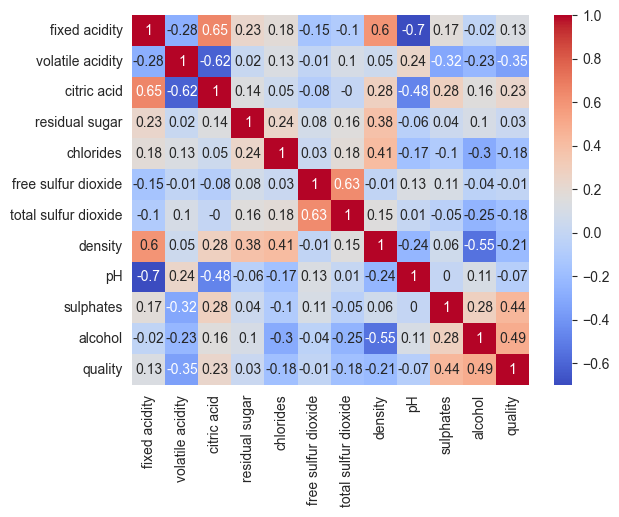

In [44]:
sns.heatmap(round(df.corr(), 2), annot=True, cmap='coolwarm');

Bringing back the correlation matrix from earlier, we can se that the feature that should have the highest impact should be density. We will define our dependent and independent variables and fit the model.

In [45]:
x = df.drop('alcohol', axis=1)
y = df['alcohol']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_test = sm.add_constant(x_train), sm.add_constant(x_test)

In [46]:
ols_model = sm.OLS(y_train, x_train).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     185.5
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          1.46e-207
Time:                        22:49:12   Log-Likelihood:                -585.47
No. Observations:                 779   AIC:                             1195.
Df Residuals:                     767   BIC:                             1251.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  592.0168 

In [47]:
predicted = ols_model.predict(x_test)
mse = mean_squared_error(y_test,predicted)
rmse = mse**0.5
print(f'RMSE: {rmse} MSE: {mse}')

RMSE: 0.460324688475372 MSE: 0.2118988188199483


In [48]:
kf = KFold(n_splits=5)
results = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    x_train, x_test = sm.add_constant(x_train), sm.add_constant(x_test)
    ols_model = sm.OLS(y_train, x_train).fit()
    predicted = ols_model.predict(x_test)
    mse = mean_squared_error(y_test,predicted)
    rmse = mse**0.5
    results.append(rmse)
validation_df = pd.DataFrame(results)
validation_df

,0
0,0.563377
1,0.606586
2,0.449782
3,0.485305
4,0.474657


In [49]:
validation_df.describe()

,0
count,5.000000
mean,0.515942
std,0.066119
min,0.449782
25%,0.474657
50%,0.485305
75%,0.563377
max,0.606586


We see that using OLS model to predict alcohol content turned out better than quality as the R^2, is closer to 1, indicating model's better fit to data when it comes to predicting alcohol content, and RMSE is really low, considering we're measuring alcohol content instead of quality. We see that the model has a collinearity issue and that some of the features are not relevant. We will be removing some of the less influential features.

In [50]:
x = df.drop(['alcohol', 'chlorides', 'free sulfur dioxide'], axis=1)
y = df['alcohol']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_test = sm.add_constant(x_train), sm.add_constant(x_test)
ols_model = sm.OLS(y_train, x_train).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     225.3
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          7.85e-209
Time:                        22:49:12   Log-Likelihood:                -588.02
No. Observations:                 779   AIC:                             1196.
Df Residuals:                     769   BIC:                             1243.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  591.1663 

In [51]:
predicted = ols_model.predict(x_test)
mse = mean_squared_error(y_test,predicted)
rmse = mse**0.5
print(f'RMSE: {rmse} MSE: {mse}')

RMSE: 0.4551525219477581 MSE: 0.20716381823540445


In [52]:
kf = KFold(n_splits=5)
results = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    x_train, x_test = sm.add_constant(x_train), sm.add_constant(x_test)
    ols_model = sm.OLS(y_train, x_train).fit()
    predicted = ols_model.predict(x_test)
    mse = mean_squared_error(y_test,predicted)
    rmse = mse**0.5
    results.append(rmse)
validation_df = pd.DataFrame(results)
validation_df

,0
0,0.564107
1,0.605811
2,0.444962
3,0.483529
4,0.474920


In [53]:
validation_df.describe()

,0
count,5.000000
mean,0.514666
std,0.067379
min,0.444962
25%,0.474920
50%,0.483529
75%,0.564107
max,0.605811


We can see that we can remove some of the less relevant features without impacting our model's performance, however that does not fix the collinearity issue. All things considered, when compared to the models when we were attempting to predict quality, this model is doing pretty well.
# Predicting Alcohol Content with Elastic Net Regression Model
Similarly to predicting quality, we will also fit elastic net regression model to predict alcohol content.

In [54]:
x = df.drop('alcohol', axis=1)
y = df['alcohol']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
alpha = 0.1
l1_ratio = 0.5
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elastic_net.fit(x_train, y_train)
y_pred = elastic_net.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
ssr = np.sum(np.square(y_pred - y_test))
print(f'Intercept: {elastic_net.intercept_}\nCoefficients: {elastic_net.coef_}\nR^2: {elastic_net.score(x_test, y_test)} RMSE: {rmse}, MSE {mse}')

Intercept: 7.993627056354459
Coefficients: [-0.03024712 -0.          0.          0.07183083 -0.          0.01471337
 -0.01071902 -0.          0.          0.          0.48158345]
R^2: 0.2549013855982375 RMSE: 0.8440722744231777, MSE 0.7124580044499162


In [55]:
kf = KFold(n_splits=5)
results = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net.fit(x_train, y_train)
    predicted = elastic_net.predict(x_test)
    mse = mean_squared_error(y_test, predicted)
    rmse = mse**0.5
    results.append(rmse)
validation_df = pd.DataFrame(results)
validation_df

,0
0,0.853983
1,0.874999
2,0.762035
3,1.044680
4,0.769506


We can see that once again similarly when we were trying to predict quality, using the elastic net regression model tends to remove too many features and penalize big coefficients, significantly lowering R^2 and raising RMSE.
# Conclusions
Working with the wine quality dataset we have:
* Removed the outliers, effectively making the data more normally distributed.
* Conducted a T-test to check whether dry or semi-sweet wines were higher quality, unfortunately we could not reject the null hypothesis and claim that one or the other wine is higher rated.
* We have tried to fit 4 different models to predict the quality of a wine based on other features in the dataset. Ultimately linear regression model using oridnary least squares method seemed to perform the best, having highest R^2, accuracy and best mean squared error measurement.
* We have fit 2 different models to predict alcohol content in a wine based on other features in the dataset. Once again linear regression model using OLS performed the best having even higher R^2 than when we tried predicting quality, as well as lower RMSE.
* It is important to keep in mind that since we removed the outliers from our dataset, using these trained models on a different dataset that would still have outliers or edge cases left in them, would ultimately reduce the performance of the models as they would not be good at predicting outside the ranges that they have been trained on.